In [8]:
import sys
sys.path.append('../')

In [9]:
from hamiltonians import Hamiltonian
from qnute_params import QNUTE_params as Params

In [10]:
import numpy as np

# Merging the two QNUTE protocols

* Input arguments: Taylor QNUTE takes extra input arguments `truncate` and `trotter_update` which should be taken in the QNUTE_params object itself.
* Circuit/Matrix representation: Since Taylor uses numerical calculations with matrices and SV uses Qiskit QuantumCircuit objects, a flag should be set in the params object to switch between these functionalities.
    * The SV sim and other qiskit based sims will all use QuantumCircuit objects for computation so the qnute implementation should keep this in mind.
* Measurement statistics: `params.num_shots` should be set to 0 to take the theoretical expectation values, otherwise the expectation values should be generated using measurement samples
* Initial state: Add precalculation of `init_sv` from `init_circ` for numerical simulations
* Drifting: Remove references to drifting protocol for now

In [11]:
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit.quantum_info import Statevector
sv_sim = Aer.get_backend('statevector_simulator')
from helpers import *
import time

In [65]:
H = Hamiltonian(
    hm_list=[ [ [3], [1.0], [0] ] ],
    lattice_dim=1,
    lattice_bound=3,
#     qubit_map={(0,0):0}
)

params = Params(H)

params.load_hamiltonian_params(
    D=1,
    reduce_dim=False,
    load_measurements=True
)

init_circ = QuantumCircuit(1)
init_circ.h(0)
params.set_run_params(
    dt=0.1,
    delta=0.1,
    N=10,
    num_shots=0,
    backend=None,
#     init_circ=init_circ,
#     init_sv=np.ones(2,dtype=complex)*np.sqrt(0.5),
    init_sv = np.ones(2**params.nbits,dtype=complex)*np.sqrt(1/(2**params.nbits)),
    taylor_norm_flag=True,
    taylor_truncate_h=-1,
    taylor_truncate_a=-1,
    trotter_flag=False
)

Performing Hamiltonian precalculations...
	Calculating Unitary Domains... Done
	Calculating Required Pauli Measurements... Done


In [69]:
params.u_domains

[[0]]

# All of these methods work under the assumption that we have access to the state vector. `params.store_state_vector = True`

In [73]:
def evolve_statevector(params: Params, qc, psi):
    '''
    Evolves the statevector psi through the circuit qc and returns the statevector
    '''
    circ = QuantumCircuit(params.nbits)
    circ.initialize(psi)
#     circ = circ + qc
    circ.compose(qc, inplace=True)
    result = execute(circ, params.backend).result()
    return result.get_statevector(circ)

In [74]:
def get_full_pauli_product_matrix(p, active, nbits):
    nactive = len(active)
    partial_pstring = int_to_base(p, 4, nactive)
    full_pstring = [0] * nbits
    for k in range(nactive):
        full_pstring[active[k]] = partial_pstring[k]
    p_mat = sigma_matrices[full_pstring[0]]
    for k in range(1,nbits):
        p_mat = np.kron(sigma_matrices[full_pstring[k]], p_mat)
    return p_mat

In [75]:
def propagate(params: Params, psi0, a_list):
    if params.circuit_flag:
        qc = QuantumCircuit(params.nbits)
        qc.initialize(psi0, list(range(params.nbits)))
        for t in range(len(a_list)):
            domain = a_list[t][1]
            ndomain = len(domain)
            ops = params.odd_y_strings[ndomain] if a_list[t][2] else list(range(4**ndomain))
            for i in range(len(ops)):
                # Skip index 0 for the non-real hamiltonian term since that's just a global phase
                if not a_list[t][2] and i == 0:
                    continue

                angle = a_list[t][0][i] * 2.0 * params.dt
                if np.abs(angle) > TOLERANCE:
                    p_dict = pauli_index_to_dict(ops[i], domain)
                    pauli_string_exp(qc, p_dict, params.H.map, angle)
        return evolve_statevector(params, qc, psi0)
    else:
        psi = np.array(psi0.data,dtype=complex) if params.circuit_flag else psi0.copy()
        for t in range(len(a_list)):
            active = [ params.H.map[k] for k in a_list[t][1]]
            nactive = len(active)
            ops = params.odd_y_strings[ndomain] if a_list[t][2] else list(range(4**nactive))
            A = np.zeros((2**params.nbits, 2**params.nbits),dtype=complex)
            for i in range(len(ops)):
                p_mat = get_full_pauli_product_matrix(i, active, params.nbits)
                A += a_list[t][0][i] * p_mat
                if params.trotter_flag:
                    psi = exp_mat_psi(-1j*a_list[t][0][i]*params.dt*p_mat, psi, truncate=params.taylor_truncate_a)
            if not params.trotter_flag:
                psi = exp_mat_psi(-1j*params.dt*A, psi, truncate=params.taylor_truncate_a)
        return Statevector(psi) if params.circuit_flag else psi

In [76]:
def pauli_expectation(params: Params, psi, p, qbits):
    '''
    returns the theoretical expectation <psi|P|psi> where P is the pauli string acting on qbits, 
    described using a Pauli string dictionary
    '''
    p_dict = pauli_index_to_dict(p, qbits)
    if params.num_shots > 0:
        if params.circuit_flag:
            qc = QuantumCircuit(params.nbits,params.nbits)
            qc.initialize(psi)
            return measure(qc, p_dict, params.H.map, params.backend, num_shots=params.num_shots)[0]
        else:
            raise ValueError('Set params.num_shots > 0 when not using QuantumCircuits')
    else:
        bases = get_qc_bases_from_pauli_dict(p_dict, params.H.map)
        active = list(bases.keys())
        p_mat = get_full_pauli_product_matrix(p, active, params.nbits)
        return np.real(np.vdot(psi.data, p_mat @ psi.data))

In [77]:
def tomography(params: Params, psi0, a_list, term):
    sigma_expectation = { 
        'c': {}, # acts on h_domains[m]
        'S': {}, # acts on u_domains[m]
        'b': {}  # acts on mix_domains[m]
    }

    psi = propagate(params, psi0, a_list)

    # If the unitary domain radius >= the hamiltonian term domain radius, all the
    # measurement operators of S cover all the measurement we need to take
    for p in params.u_measurements[term]:
        sigma_expectation['S'][p] = pauli_expectation(params, psi, p, params.u_domains[term])
    # Otherwise, we need to account for all the different measurement domains
    if params.small_u_domain_flags[term]:
        for p in params.h_measurements[term]:
            sigma_expectation['c'][p] = pauli_expectation(params, psi, p, params.h_domains[term])
        for p in params.mix_measurements[term]:
            sigma_expectation['b'][p] = pauli_expectation(params, psi, p, params.mix_domains[term])
        
    return sigma_expectation

In [87]:
def update_alist(params: Params, sigma_expectation, a_list, term, psi0, scale):
    hm = params.H.hm_list[term]
    num_terms = len(hm[0])
    u_domain = params.u_domains[term]
    ndomain = len(u_domain)

    def full_pauli_index(p, d1, d2):
        index = 0
        for i in range(len(d1)):
            gate = p % 4
            
            qbit = d1[i]
            # find the index of qbit in d2
            j=0
            while d2[j] != qbit:
                j += 1
                if j == len(d2):
                    raise ValueError('Element {} not found in domain {}'.format(d1[i],d2) )

            index += gate * 4**j
            p = p//4
        return index
    
    # Load c
    if params.taylor_norm_flag:
        h_mat = params.H.get_term_submatrix(term)
        psi_prime = exp_mat_psi(params.dt*h_mat, psi0, truncate=params.taylor_truncate_h)
        c = np.linalg.norm(psi_prime)
    else:
        c = 1.0
        for j in range(num_terms):
            if params.small_u_domain_flags[term]:
                key1 = 'c'
                key2 = params.h_measurements[term][j]
            else:
                key1 = 'S'
                key2 = full_pauli_index(params.h_measurements[term][j], 
                                        params.h_domains[term], 
                                        params.u_domains[term])
            c += 2*scale * params.dt * np.real(hm[1][j]) * sigma_expectation[key1][key2]
        c = np.sqrt(c)
    
    # Load S
    if params.H.real_term_flags[term] and params.reduce_dimension_flag:
        ops = params.odd_y_strings[ndomain]
    else:
        ops = list(range(4**ndomain))
    nops = len(ops)
    
    S = np.zeros((nops,nops), dtype=complex)
    for i in range(nops):
        I = ops[i]
        for j in range(0,i):
            J = ops[j]
            p_,c_ = pauli_string_prod(I, J, ndomain)
            S[i,j] = sigma_expectation['S'][p_] * c_
            # S is Hermitian, so we know the upper triangle
            S[j,i] = S[i,j].conjugate()
        # The diagonal is full of 1s: <psi|I|psi>
        S[i,i] = 1.0
    
    # Load b
    b = np.zeros(nops, dtype=complex)
    for i in range(nops):
        if params.small_u_domain_flags[term]:
            key1 = 'b'
            I = full_pauli_index(ops[i], 
                                u_domain, 
                                params.mix_domains[term])
        else:
            key1 = 'S'
            I = ops[i]
        for j in range(num_terms):
            if params.small_u_domain_flags[term]:
                J = full_pauli_index(params.h_measurements[term][j], 
                                    params.h_domains[term], 
                                    params.mix_domains[term])
            else:
                J = full_pauli_index(params.h_measurements[term][j],
                                    params.h_domains[term],
                                    u_domain)

            if params.small_u_domain_flags[term]:
                p_,c_ = pauli_string_prod(I, J, len(params.mix_domains[term]))
            else:
                p_,c_ = pauli_string_prod(I, J, ndomain)

            b[i] += scale * np.imag(hm[1][j] * c_) * sigma_expectation[key1][p_]
    b = -(2.0 / c) * b

    #Regularizer
    dalpha = np.eye(nops) * params.delta
    
    a = np.real(np.linalg.lstsq(2*np.real(S) + dalpha, b, rcond=-1)[0])
    
    a_list.append([a, u_domain, params.H.real_term_flags[term] and params.reduce_dimension_flag])
    return S,b,c

In [82]:
def qnute_step(params: Params, psi0):
    a_list = []
    S_list = []
    b_list = []
    c_list = []
    
    H = params.H
    
    for term in range(H.num_terms):
        sigma_expectation = tomography(params, psi0, a_list, term)
        S,b,c = update_alist(params, sigma_expectation, a_list, term, propagate(params, psi0, a_list), 1.0)
        S_list.append(S)
        b_list.append(b)
        c_list.append(c)

    return a_list, S_list, b_list, c_list, propagate(params, psi0, a_list)

In [83]:
def qnute(params:Params, log_to_console:bool=True):
    times = np.zeros(params.N + 1)
    svs = np.zeros((params.N+1, 2**params.nbits), dtype=complex)
    svs[0,:] = params.init_sv.data

    a_list = []
    S_list = []
    b_list = []
    c_list = []
    
    if log_to_console: print('Starting QNUTE Iterations:')
    
    for i in range(1, params.N+1):
        if log_to_console: print('Iteration {}...'.format(i),end=' ',flush=True)
        
        t0 = time.time()
        
        next_alist, next_slist, next_blist, next_clist, phi = qnute_step(params, svs[i-1])
        a_list += next_alist
        S_list += next_slist
        b_list += next_blist
        c_list += next_clist
        svs[i,:] = phi.data
        
        t1 = time.time()
        duration = t1-t0
        times[i] = duration
        
        if log_to_console: print('Done -- Iteration time = {:0.2f} {}'.format(duration if duration < 60 else duration/60, 'seconds' if duration < 60 else 'minutes'))
    
    return times, svs, a_list, S_list, b_list, c_list

In [84]:
times, svs, a_list, S_list, b_list, c_list = qnute(params, True)

Starting QNUTE Iterations:
Iteration 1... Done -- Iteration time = 0.00 seconds
Iteration 2... Done -- Iteration time = 0.00 seconds
Iteration 3... Done -- Iteration time = 0.00 seconds
Iteration 4... Done -- Iteration time = 0.00 seconds
Iteration 5... Done -- Iteration time = 0.00 seconds
Iteration 6... Done -- Iteration time = 0.00 seconds
Iteration 7... Done -- Iteration time = 0.00 seconds
Iteration 8... Done -- Iteration time = 0.00 seconds
Iteration 9... Done -- Iteration time = 0.00 seconds
Iteration 10... Done -- Iteration time = 0.00 seconds


In [85]:
svs[0]

array([0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j,
       0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j])

In [86]:
svs[-1]

array([0.49442775+0.j, 0.07443882+0.j, 0.49442775+0.j, 0.07443882+0.j,
       0.49442775+0.j, 0.07443882+0.j, 0.49442775+0.j, 0.07443882+0.j])

In [62]:
np.kron([0,1], [0,1])

array([0, 0, 0, 1])

In [119]:
np.sqrt(np.prod(c_list))*svs[-1]

array([1.72959257+0.j, 0.25556586+0.j])

In [120]:
[ [np.exp(params.N*params.dt),0],
  [0, np.exp(-params.N*params.dt)]
] @ params.init_sv.data

array([1.92211551+0.j, 0.26013005+0.j])

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline

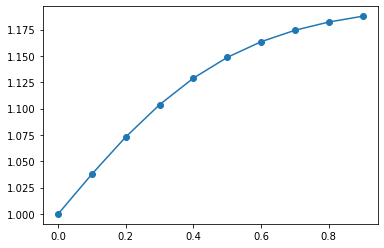

In [111]:
plt.plot(np.arange(0,len(c_list),1)*params.dt, c_list,'o-')
plt.show()

In [131]:
psis = np.zeros((params.N+1,2),dtype=complex)
psis[0] = params.init_sv.data
b = np.zeros(params.N+1,dtype=float)
b[0] = 1.0
phis = np.zeros(psis.shape,dtype=complex)
c = np.zeros(b.shape,dtype=float)
c[0] = 1.0
for i in range(1,params.N+1,1):
    psis[i][0] = np.exp(params.dt)*psis[i-1][0]
    psis[i][1] = np.exp(-params.dt)*psis[i-1][1]
    b[i] = np.linalg.norm(psis[i])
    
    chi = psis[i-1]/b[i-1]
    phis[i][0] = np.exp(params.dt)*chi[0]
    phis[i][1] = np.exp(-params.dt)*chi[1]
    c[i] = np.linalg.norm(phis[i])

In [139]:
len(c_list)

10

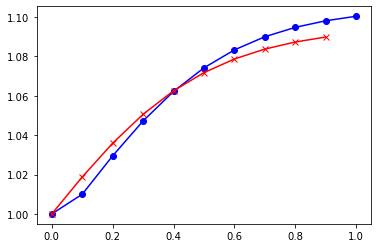

In [141]:
a0 = np.exp(np.arange(0,params.N+1,1)*params.dt)*np.sqrt(0.5)
a1 = np.exp(-np.arange(0,params.N+1,1)*params.dt)*np.sqrt(0.5)
a = np.sqrt(a0**2 + a1**2)

# plt.plot(np.arange(0,params.N+1,1)*params.dt, b, 'r-')
plt.plot(np.arange(0,params.N+1,1)*params.dt, c, 'bo-')
plt.plot(np.arange(0,params.N,1)*params.dt, np.sqrt(c_list),'rx-')
plt.show()

In [144]:
np.sqrt(np.prod(c_list))/np.prod(c[1:])

0.9013908244313341